# Introduction

<p>In a United Parcel Service (UPS) package sorting facility, also known as a hub, packages that are not large enough to be sorted individually on the main conveyor belts are automatically sent to an area of the hub known as “small sort” to become “containerized.” This is the process of combining packages that have similar service levels and similar final delivery destinations into bags so that the bag can be routed to its delivery vehicle. The list of packages destined for the same bag will be referred to as a “load.”</p>
&nbsp;&nbsp;
<p>In most UPS hubs, a tilt-tray conveyor system is used to drop packages into the correct bags. When a bag becomes full, an employee needs to promptly zip up the bag, print out a label, place the label on the bag, place the bag onto a conveyor belt where it will be routed to the appropriate delivery vehicle, and place an empty bag in its place so that more packages can be dropped in that bin position. A “bin position” or “bin” is defined as a single position alongside the tilt tray where packages can be dropped and where bags are placed to catch them. The goal of this project is to present a mathematical model known as a linear program that effectively assigns loads to bin positions in a manner that maximizes the productivity of the employees processing the volume.</p>


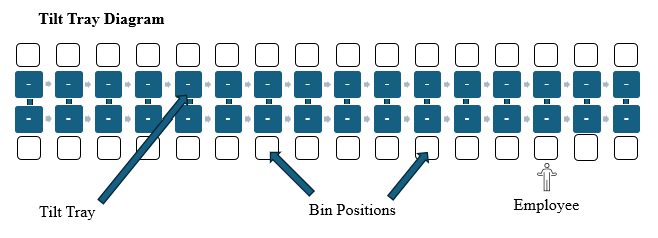

# Part 1 - Mathematical Formulation of the Problem as a Linear Program
---

<p>An assignment linear programming (LP) problem is a type of optimization problem where the goal is to assign a set of tasks to a set of agents to minimize or maximize a linear objective function that is subject to linear constraints. In the load-to-bin assignment LP problem presented in this project, the objective function is the sum of the cost for every assignment made. Hence, the goal is to minimize this function while satisfying the constraints that every load be assigned to one bin position and every bin position be assigned one load.</p>

&nbsp;
### Assumptions and Initial Conditions

1. The information needed to model the problem is a list of loads that are awaiting a bin assignment and the corresponding expected volume (expected number of packages) for each of these loads. The expected volume data can be obtained from a UPS corporate database by a UPS industrial engineer. For data privacy, this data is generated randomly from a uniform distribution in this project.

2. The model assumes that the number of loads that need to be assigned is equal to the number of bins available. In the case where the number of loads awaiting assignment is less than the number of bins available, “dummy” loads are created that receive zero package volume to make the number of loads equal the number of bins. In the case where the number of loads awaiting assignment is greater than the number of bins available, the problem is declared to not be feasible, and the user will need to arbitrarily combine loads together to reduce the number of loads.

3. This formulation assumes that the number of employees working in the tilt-tray operations is known prior to solving the problem. This information is used during the process of computing appropriate cost coefficients for the linear objective function.


&nbsp;
### Components of the Model

#### 1. Cost Coefficients

* To create an objective function, a cost or penalty for every possible assignment possibility is needed. For example, if load $l_i$ is assigned to bin $b_j$, there needs to be a cost so that the objective function can be increased by this amount. This value will be represented by $c_{ij}$.
* The selecting of appropriate cost coefficients is the most critical element that enables the assignment LP model to effectively create an optimal load to bin assignment plan. The method is as follows:

  * Let $n$ represent the number of loads that need to be assigned to a bin position
  * Let $m$ represent the number of employees available to process packages on the tilt-tray
  * Let $L=\{l_1,l_2,…,l_n\}$ be the set of loads
  * Let $V=\{v_1,v_2,…,v_n\}$ be the set of volumes where $v_i$ is the expected volume for load $l_i$
  * Let  $B=\{b_1,b_2,…,b_n\}$ be set of bin positions available to receive a load assignment
  * Let $ϕ=⌊\frac{n}{m}⌋$. This signifies that 𝜙 is the greatest integer less than or equal to the division of $𝑛$ by $𝑚$
  * Let $ψ=⌊\frac{n-(ϕ \cdot m)}{2}⌋$. This signifies that ψ is the greatest integer less than or equal to the division of $(n-(ϕ∙m))$ by $2$.
  * Let $H=\{h_1,h_2,…,h_m\}$ where $h_k=ψ+k \cdot ϕ+⌊ϕ/2⌋$,$∀k∈\{1,2,…,m\}$
  * Let $D=\{d_1,d_2,…,d_n\}$ where $d_j=\min⁡|h_k-j|,∀h_k∈H$
  * Let $c_{ij}=v_i \cdot d_j$

&nbsp;
#### 2. Objective Function

* The decision variables in the objective function will be represented by $x_{ij}$.

$$x_{ij} \in \{0,1\}$$


$$x_{ij} =
\begin{cases}
    1 & \text{if load } l_i \text{ is assigned to bin } b_j \\
    0 & \text{otherwise}
\end{cases}$$


* The objective function containing cost coefficients and decision variables is as follows:

$$min \sum_{i=1}^{n} \sum_{j=1}^{n} c_{ij} \cdot x_{ij}$$

&nbsp;
#### 3. Constraints

* Every load must be assigned to only one bin:

$$\sum_{i=1}^{n} x_{ij}=1$$

* Every bin must have only one load assigned to it:

$$\sum_{j=1}^{n} x_{ij}=1$$



# Part 2 - Understanding the Model
---

### Why does this formulation produce an "optimal" load-to-bin assingment plan?

<p>
An "optimal" load-to-bin assingment plan is one in which employees can be most efficient processing bags in need of service. Being efficient in this context means spending more time productively replacing bags as they become full and less time traveling between bin positions to arrive at a bin in need of service.
</p>
&nbsp;
<p>
The model acheives such a plan by first choosing several bin positons to be "home positions." The number of home positions is equal to the total amount of employees to be working in the tilt-tray operation. Home positions are spaced out at an equal distance from each other.
</p>
&nbsp;
<p>
The model then tries to place the loads with the highest expected volume closest to these home positions. The model acheives this because the cost coefficient in the linear objective function for load $l_i$ being assigned to bin $b_j$ is the expected volume for load $l_i$ (represented by $v_i$), multiplied by the distance that bin $b_j$ is from the nearest home position. This effectively "incentivizes" the model to place loads with relatively high expected volume closer to home positions since the objective is to minimize the sum of the cost of all assignments.
</p>
&nbsp;
<p>
The idea is that each employee has a designated home positon. In an optimal plan, the bin positons closest to home positions are the ones that will need to be serviced most frequenlty due to the loads assigned to these bin positons having reletively higher expected volume than loads assigned farther away from a home position. This layout requires less walking between bin positons to arrive a bin in need of service and allows employees to spend the bulk of their time productively replacing bags as they become full.
</p>

# Part 3 - Python Implementation
---

## Step 1: Generate a Dataframe for Loads

### Columns:

1. Load Name

  * Contains a list of load names.

2. Expected Volume

  * Contains the expected package volume for each load.
  * In practice, this data can be obtained from a UPS corporate database by a UPS industrial engineer but is generated randomly from a uniform distribution in this project for the purpose of data privacy.

In [20]:
import numpy as np
import pandas as pd
import random

# Parameters
num_loads = 100       # Number of loads needing bin assignment
low = 0               # Lowest Possible Expected Volume in uniform distribution
high = 200            # Highest Possible Expected Volume in uniform distribution

# Generate Column 1: Load Names
load_names = [f"Load {i+1}" for i in range(num_loads)]

# Generate Column 2: Expected Volume
expected_volume = [round(random.uniform(low, high),2) for _ in range(num_loads)]

# Create the DataFrame
loads_df = pd.DataFrame({
    "Load Name": load_names,
    "Expected Volume": expected_volume,
})

loads_df.head(20)

,Load Name,Expected Volume
0,Load 1,45.37
1,Load 2,194.53
2,Load 3,160.42
3,Load 4,31.25
4,Load 5,30.01
5,Load 6,110.77
6,Load 7,168.12
7,Load 8,124.41
8,Load 9,1.41
9,Load 10,184.71


## Step 2: Generate a Dataframe for Bin Positions

### Columns:

1. Bin Position Name

  * This column contains a list of bin position names.

2. Distance

  * The value in this column represents the distance (in terms of number of bin positions) that the corresponding bin position is from a home position.
  * These values are important in the next step of model, creating a cost coefficeint matrix.


In [21]:
# Parameters
num_bins = num_loads  # Number of bins is assumed to be equal to the number of loads needing bin assignment
num_employees = 4     # Number of employees working on tilt-tray operation

# Generate Column 1: Bin Position Names
bin_names = [f"Bin {i+1}" for i in range(num_bins)]

# Generate Column 2: Distances
home_position = np.zeros(num_employees, dtype=int)
interval = num_bins // num_employees
start_point = (num_bins - (interval * num_employees)) // 2

for k in range(num_employees):
    home_position[k] = start_point + k * interval + interval // 2

print(home_position)

distances = np.zeros(num_bins)

for j in range(0, num_bins):
  min_distance = np.inf
  for h_k in home_position:
    min_distance = min(min_distance, abs(h_k - j))
  distances[j] = min_distance

# Create the DataFrame
bins_df = pd.DataFrame({
    "Bin Name": bin_names,
    "Distance": distances
})

bins_df.head(20)

[12 37 62 87]


,Bin Name,Distance
0,Bin 1,12.0
1,Bin 2,11.0
2,Bin 3,10.0
3,Bin 4,9.0
4,Bin 5,8.0
5,Bin 6,7.0
6,Bin 7,6.0
7,Bin 8,5.0
8,Bin 9,4.0
9,Bin 10,3.0


## Step 3: Creating a Cost Cost Coefficent Matrix


In [22]:
# Create Cost Coefficent Matrix

load_vol = loads_df['Expected Volume']
multiplier = bins_df['Distance']

matrix = np.zeros((num_loads, num_bins))

for i in range(num_loads):
    for j in range(num_bins):
      matrix[i, j] = multiplier[i]*load_vol[j]

cost_coefficients_df = pd.DataFrame(matrix, columns=[f'Load {i+1}' for i in range(num_loads)], index=[f'Bin {i+1}' for i in range(num_bins)])

cost_coefficients_df.head(20)

,Load 1,Load 2,Load 3,Load 4,Load 5,Load 6,Load 7,Load 8,Load 9,Load 10,Load 11,Load 12,Load 13,Load 14,Load 15,Load 16,Load 17,Load 18,Load 19,Load 20,Load 21,Load 22,Load 23,Load 24,Load 25,Load 26,Load 27,Load 28,Load 29,Load 30,Load 31,Load 32,Load 33,Load 34,Load 35,Load 36,Load 37,Load 38,Load 39,Load 40,Load 41,Load 42,Load 43,Load 44,Load 45,Load 46,Load 47,Load 48,Load 49,Load 50,Load 51,Load 52,Load 53,Load 54,Load 55,Load 56,Load 57,Load 58,Load 59,Load 60,Load 61,Load 62,Load 63,Load 64,Load 65,Load 66,Load 67,Load 68,Load 69,Load 70,Load 71,Load 72,Load 73,Load 74,Load 75,Load 76,Load 77,Load 78,Load 79,Load 80,Load 81,Load 82,Load 83,Load 84,Load 85,Load 86,Load 87,Load 88,Load 89,Load 90,Load 91,Load 92,Load 93,Load 94,Load 95,Load 96,Load 97,Load 98,Load 99,Load 100
Bin 1,544.44,2334.36,1925.04,375.00,360.12,1329.24,2017.44,1492.92,16.92,2216.52,1655.04,1368.96,1833.00,1877.04,2194.08,1851.48,2115.96,1612.44,974.88,1916.4,2094.12,311.16,328.32,1390.8,1684.20,1254.96,1893.12,2103.96,887.88,1748.88,1946.76,2240.4,205.2,2275.68,267.96,1988.4,1397.76,1006.44,933.36,1215.36,2381.52,1691.04,1507.68,760.56,1438.44,1031.64,970.68,975.6,395.40,429.00,825.6,1752.48,442.44,1172.4,187.44,582.96,753.6,1086.12,2091.96,1749.96,1476.24,960.84,2239.56,67.68,2341.44,56.4,2361.96,426.96,581.76,203.04,1537.56,348.0,1530.96,2338.20,2062.92,1765.32,1063.68,121.44,1871.88,427.56,404.64,925.80,1976.04,1146.60,576.48,456.72,1371.84,1019.88,387.84,1058.4,1344.96,2183.16,1618.08,1449.12,967.44,1998.60,2241.36,73.08,1447.08,1249.44
Bin 2,499.07,2139.83,1764.62,343.75,330.11,1218.47,1849.32,1368.51,15.51,2031.81,1517.12,1254.88,1680.25,1720.62,2011.24,1697.19,1939.63,1478.07,893.64,1756.7,1919.61,285.23,300.96,1274.9,1543.85,1150.38,1735.36,1928.63,813.89,1603.14,1784.53,2053.7,188.1,2086.04,245.63,1822.7,1281.28,922.57,855.58,1114.08,2183.06,1550.12,1382.04,697.18,1318.57,945.67,889.79,894.3,362.45,393.25,756.8,1606.44,405.57,1074.7,171.82,534.38,690.8,995.61,1917.63,1604.13,1353.22,880.77,2052.93,62.04,2146.32,51.7,2165.13,391.38,533.28,186.12,1409.43,319.0,1403.38,2143.35,1891.01,1618.21,975.04,111.32,1715.89,391.93,370.92,848.65,1811.37,1051.05,528.44,418.66,1257.52,934.89,355.52,970.2,1232.88,2001.23,1483.24,1328.36,886.82,1832.05,2054.58,66.99,1326.49,1145.32
Bin 3,453.70,1945.30,1604.20,312.50,300.10,1107.70,1681.20,1244.10,14.10,1847.10,1379.20,1140.80,1527.50,1564.20,1828.40,1542.90,1763.30,1343.70,812.40,1597.0,1745.10,259.30,273.60,1159.0,1403.50,1045.80,1577.60,1753.30,739.90,1457.40,1622.30,1867.0,171.0,1896.40,223.30,1657.0,1164.80,838.70,777.80,1012.80,1984.60,1409.20,1256.40,633.80,1198.70,859.70,808.90,813.0,329.50,357.50,688.0,1460.40,368.70,977.0,156.20,485.80,628.0,905.10,1743.30,1458.30,1230.20,800.70,1866.30,56.40,1951.20,47.0,1968.30,355.80,484.80,169.20,1281.30,290.0,1275.80,1948.50,1719.10,1471.10,886.40,101.20,1559.90,356.30,337.20,771.50,1646.70,955.50,480.40,380.60,1143.20,849.90,323.20,882.0,1120.80,1819.30,1348.40,1207.60,806.20,1665.50,1867.80,60.90,1205.90,1041.20
Bin 4,408.33,1750.77,1443.78,281.25,270.09,996.93,1513.08,1119.69,12.69,1662.39,1241.28,1026.72,1374.75,1407.78,1645.56,1388.61,1586.97,1209.33,731.16,1437.3,1570.59,233.37,246.24,1043.1,1263.15,941.22,1419.84,1577.97,665.91,1311.66,1460.07,1680.3,153.9,1706.76,200.97,1491.3,1048.32,754.83,700.02,911.52,1786.14,1268.28,1130.76,570.42,1078.83,773.73,728.01,731.7,296.55,321.75,619.2,1314.36,331.83,879.3,140.58,437.22,565.2,814.59,1568.97,1312.47,1107.18,720.63,1679.67,50.76,1756.08,42.3,1771.47,320.22,436.32,152.28,1153.17,261.0,1148.22,1753.65,1547.19,1323.99,797.76,91.08,1403.91,320.67,303.48,694.35,1482.03,859.95,432.36,342.54,1028.88,764.91,290.88,793.8,1008.72,1637.37,1213.56,1086.84,725.58,1498.95,1681.02,54.81,1085.31,937.08
Bin 5,362.96,1556.24,1283.36,250.00,240.08,886.16,1344.96,995.28,11.28,1477.68,1103.36,912.64,1222.00,1251.36,1462.72,1234.32,1410.64,1074.96,649.92,1277.6,1396.08,207.44,218.88,927.2,1122.80,836.64,1262.08,1402.64,591.92,

## Step 4: Solving the Linear Program

In [23]:
!pip install pulp
from pulp import *

In [24]:
from pulp import LpMinimize, LpProblem, LpVariable, lpSum

# Assume cost_coefficients_df has been defined and has the appropriate costs.

# Define the problem
prob = LpProblem("AssignmentProblem", LpMinimize)

# Define the decision variables
x = LpVariable.dicts("x", [(i, j) for i in range(num_bins) for j in range(num_loads)], cat='Binary')

# Objective function: Minimize the total cost
prob += lpSum([cost_coefficients_df.iloc[i, j] * x[(i, j)] for i in range(num_bins) for j in range(num_loads)])

# Constraints: Each bin is assigned to exactly one load
for i in range(num_bins):
    prob += lpSum([x[(i, j)] for j in range(num_loads)]) == 1

# Constraints: Each load is assigned to exactly one bin
for j in range(num_loads):
    prob += lpSum([x[(i, j)] for i in range(num_bins)]) == 1

# Solve the problem
prob.solve()

# Extract the assignments
assignments = [(i, j) for i in range(num_bins) for j in range(num_loads) if x[(i, j)].varValue == 1]

# Create a DataFrame to display the assignments
result_df = pd.DataFrame(assignments, columns=['Bin', 'Load'])

# Add Bins column with numbers counting from 1 to num_bins
result_df['Bin Position'] = result_df['Bin'] + 1

# Add Load names and Expected Volume from the loads_df
result_df['Load Name'] = result_df['Load'].apply(lambda x: loads_df.at[x, 'Load Name'])
result_df['Expected Volume'] = result_df['Load'].apply(lambda x: loads_df.at[x, 'Expected Volume'])

# Rearrange columns
result_df = result_df[['Bin Position', 'Load Name', 'Expected Volume']]

# Create horizontal bars starting from the left
max_length = 20  # Maximum length of the bar
max_value = result_df['Expected Volume'].max()
result_df['Bar'] = result_df['Expected Volume'].apply(lambda x: '█' * int(max_length * (x / max_value)))

# Rearrange columns
result_df = result_df[['Bin Position', 'Load Name', 'Expected Volume', 'Bar']]

# Set options to display the entire DataFrame
pd.set_option('display.max_rows', None)  # Show all rows
pd.set_option('display.max_columns', None)  # Show all columns
pd.set_option('display.width', None)  # Adjust the width to the screen's width
pd.set_option('display.max_colwidth', None)  # Show full column content

# Display the DataFrame
result_df



,Bin Position,Load Name,Expected Volume,Bar
0,1,Load 78,10.12,█
1,2,Load 4,31.25,███
2,3,Load 86,38.06,███
3,4,Load 57,62.80,██████
4,5,Load 19,81.24,████████
5,6,Load 40,101.28,██████████
6,7,Load 91,112.08,███████████
7,8,Load 73,127.58,████████████
8,9,Load 30,145.74,██████████████
9,10,Load 3,160.42,████████████████


# Part 4 - Next Steps (In-Progress)
---

1. Discuss computational time and complexity
2. Compare results to "heuristic sort" method where bin assignments are chosen by ranking loads based on expected volume are assigned bin so that peaks in expected volume occurs at home positions
3. Explore the possibilty of making home position a binary decision variable instead requiring the location of home positions to be a known prior to solving the problem